# Random Forest Model tuning

Let's see how much improvement can be made on a default random forest model via hyperparameter optimization. We'll work most of our tuning on 10% sample of the entire training set. 

# Set up

In [2]:
import pandas as pd
import zipfile 
from zipfile import ZipFile 


file_name = "playground-series-s4e7.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
df_zip = zipfile.ZipFile(file_name)
train = pd.read_csv(df_zip.open('train.csv'))

# import sample
import random

n = len(train) # Calculate number of rows in file
s = n//10  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))   
train_sample = pd.read_csv(df_zip.open('train.csv'), skiprows = skip)
train_sample


File Name                                             Modified             Size
sample_submission.csv                          2024-06-24 13:46:18     99708270
test.csv                                       2024-06-24 13:46:24    433918183
train.csv                                      2024-06-24 13:46:48    662779095


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
1,5,Female,31,1,47.0,1,< 1 Year,No,28150.0,152.0,197,0
2,13,Male,27,1,28.0,1,< 1 Year,No,43746.0,152.0,259,0
3,15,Male,79,1,8.0,0,> 2 Years,Yes,66887.0,124.0,150,0
4,17,Female,20,1,50.0,1,< 1 Year,No,36389.0,160.0,242,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150474,11504726,Female,36,1,3.0,0,1-2 Year,Yes,18090.0,124.0,159,1
1150475,11504738,Male,24,1,17.0,0,< 1 Year,Yes,2630.0,160.0,105,0
1150476,11504771,Male,32,1,44.0,0,1-2 Year,Yes,2630.0,26.0,270,0
1150477,11504777,Male,42,1,3.0,0,1-2 Year,Yes,47788.0,26.0,283,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


 # Reduce Memory

To reduce memory load we'll change some column types to more memory-friendly formats. 

In [4]:
# drop id
train = train.drop('id', axis = 1)

# convert obj to cat
categorical = ["Region_Code", "Policy_Sales_Channel", "Gender", "Vehicle_Damage", "Vehicle_Age"]
train[["Region_Code", "Policy_Sales_Channel"]] = train[["Region_Code", "Policy_Sales_Channel"]].astype('int32')
train[categorical] = train[categorical].astype("category")

# train sample
train[["Region_Code", "Policy_Sales_Channel"]] = train[["Region_Code", "Policy_Sales_Channel"]].astype('int32')
train[categorical] = train[categorical].astype("category")

# convert numerics into int 32 

import numpy as np
# integer
d = dict.fromkeys(train.select_dtypes(np.int64).columns, np.int32)
train = train.astype(d)

# float
d2 = dict.fromkeys(train.select_dtypes(np.float64).columns, np.int32)
train = train.astype(d2)

## Sample

In [5]:
train_sample = train_sample.drop('id', axis = 1)

# convert obj to cat
train_sample[["Region_Code", "Policy_Sales_Channel"]] = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype('int64')
train_sample[categorical] = train_sample[categorical].astype("category")

# train_sample sample
train_sample[["Region_Code", "Policy_Sales_Channel"]] = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype('int64')
train_sample[categorical] = train_sample[categorical].astype("category")

# convert numerics into int 32 

import numpy as np
# integer
d = dict.fromkeys(train_sample.select_dtypes(np.int64).columns, np.int64)
train_sample = train_sample.astype(d)

# float
d2 = dict.fromkeys(train_sample.select_dtypes(np.float64).columns, np.int64)
train_sample = train_sample.astype(d2)


# Split

In [6]:
from sklearn.model_selection import train_test_split
X = train.drop("Response", axis = 1)
y = train["Response"]


X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)

## Sample

In [7]:
Xs = train_sample.drop("Response", axis = 1)
ys = train_sample["Response"]


Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs,ys,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = ys)

# Preprocessing

## Column groups

In [8]:
unique_values = Xs_train.select_dtypes(include = ['object', 'category']).nunique()

binary_cat = unique_values.index[unique_values == 2].tolist()
ordinal_cat = ["Vehicle_Age"]
target_cat = unique_values.index[unique_values > 20].tolist()
categorical = Xs_train.select_dtypes(include = ['object', 'category']).columns.values.tolist()
categorical.remove("Vehicle_Age")
nominal_cat = list(set(categorical).difference(binary_cat))

vehicle_age_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# numerical transformer
num_col = ['Age','Annual_Premium','Vintage']


## Encoders

In [9]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder

# ordinal encoder
ordinal = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']])),
])
# target encoder
target = Pipeline(steps=[
    ("target", TargetEncoder()),
])

# ohe encoder
ohe  = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown= 'ignore')),
])

# dummy encoder
binary = Pipeline(steps=[
    ("dummy",BinaryEncoder()),
])

num_pipe = Pipeline(steps=[
    ("standardize", StandardScaler()) # standardize
])


## Preprocessing pipe

In [10]:
from sklearn.compose import ColumnTransformer

default = ColumnTransformer(
    transformers=[
        ("ord", ordinal, ordinal_cat),
        ("dummy", binary, binary_cat),
        ("num", num_pipe, num_col),
        ("target",target, nominal_cat)
    ],
    remainder = "passthrough"
    
)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose = 2, n_jobs = -1, random_state = 42,class_weight = "balanced_subsample") 

default_rf = Pipeline(steps=[
          ('column_tran',default),
          ('model',rf)
     ])

In [25]:
default_rf.fit(Xs_train, ys_train)
pred_default_rf = default_rf.predict(Xs_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100building tree 30 of 100

building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.5s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100building tree 44 of 100
building tree 45 of 100
building tree 46 of 100

building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100building tree 52 of 100
building tree 53 of 100building tree 54 of 100


building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100building tree 76 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished


# Default model

## Performance

In [ ]:
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score
acc = accuracy_score(ys_val,pred_default_rf )
ps = precision_score(ys_val, pred_default_rf)
rec = recall_score(ys_val,pred_default_rf)
f1 = f1_score(ys_val, pred_default_rf)
acc , ps ,rec, f1

In [140]:
default_rf['model'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

Our default random forest has a 86.7% accuracy, a little lower than our naive model run. Looking back, I believe that both nominal variables (Policy_Sales_Channel, Region_Code) were both ignored in the previous notebook. This performance difference is likely due to our explicit target-encoding of these two variables. Let's look at other details of the default.

## Depth

avg max depth 62.9


<Axes: ylabel='Count'>

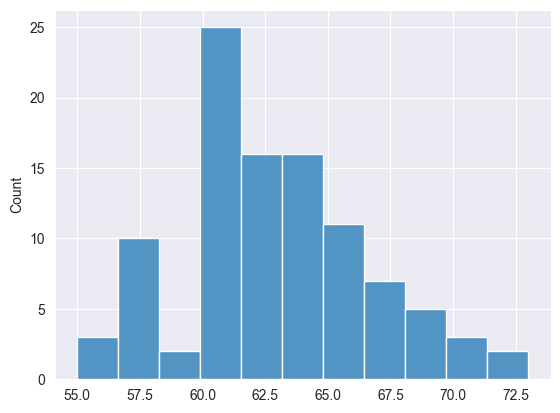

In [27]:
max_depth = list()

for tree in default_rf['model'].estimators_:
    max_depth.append(tree.tree_.max_depth)

print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))

import seaborn as sns
sns.histplot(data = max_depth)

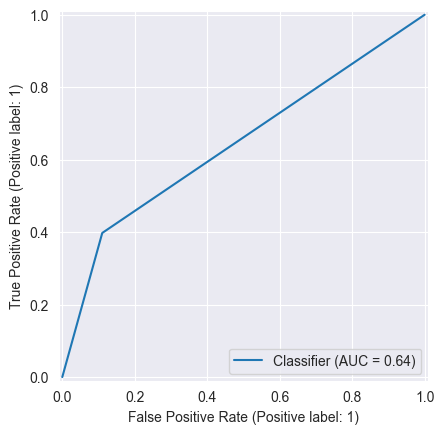

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_predictions(pred_default_rf, ys_val, ax=ax)
plt.show()

In [127]:
global_importances = pd.Series(default_rf['model'].feature_importances_, index=default_rf['column_tran'].get_feature_names_out())
global_importances

ord__Vehicle_Age                 0.020632
dummy__Gender_0                  0.002106
dummy__Gender_1                  0.002269
dummy__Vehicle_Damage_0          0.105734
dummy__Vehicle_Damage_1          0.128386
num__Age                         0.119433
num__Annual_Premium              0.179318
num__Vintage                     0.186771
target__Policy_Sales_Channel     0.080927
target__Region_Code              0.073096
remainder__Driving_License       0.000606
remainder__Previously_Insured    0.100722
dtype: float64

In [126]:
default_rf['model'].feature_importances_

array([0.02063184, 0.00210575, 0.00226885, 0.10573366, 0.12838557,
       0.11943334, 0.17931813, 0.18677141, 0.0809275 , 0.07309619,
       0.00060582, 0.10072194])

In [124]:
default_rf['column_tran'].get_feature_names_out()

array(['ord__Vehicle_Age', 'dummy__Gender_0', 'dummy__Gender_1',
       'dummy__Vehicle_Damage_0', 'dummy__Vehicle_Damage_1', 'num__Age',
       'num__Annual_Premium', 'num__Vintage',
       'target__Policy_Sales_Channel', 'target__Region_Code',
       'remainder__Driving_License', 'remainder__Previously_Insured'],
      dtype=object)

In [119]:

forest_importances = pd.Series(importances, index=feature_names)
feature_names = [f"feature {i}" for i in range(Xs_train.shape[1])]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

NameError: name 'feature_names' is not defined

# Model tuning

Now that we have our baseline random forest model, let's try tuning a model and see if it does better! Hyperoptimization can be done in several ways, including but not limited to:
- Grid search: We specify a finite set of values for each hyperparameter and the grid search evaluates a cartesian product of these values. The method is limited to the values we define and since the grid search evaluates all combinations, this method suffers from dimensionality of our hyperparameter space.
- Random search: We also specify a finite set of values. However, random search will evaluate combinations, well, randomly until a stopping criteria is met. This is useful for trying out varying combinations of our hypothesized values to test what seems to work. This is typically be used to start an optimization process by finding promising values and then fine-tuning with a grid search around those initial values. 
- Bayesian Optimization: We define a range of hyperparameter values and this method uses a function to determine which combination to test each round. Specifically, we define an 'objective' function (eg accuracy) that is then approximated by Bayesian Optimizer as a probability model. This probability model is then used to estimate the next selections of hyperparameters values that yield the highest Expected Improvement. If you want to learn more about how this is done, you can check out Tree Parzen Estimators (TPE)(https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f) and the (Hyperopt)[https://hyperopt.github.io/hyperopt/ ] documentation.



## Bayesian Optimization

In [ ]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, STATUS_FAIL, space_eval
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np


Xs_trans = default.transform(Xs_train)
space = {'criterion': hp.choice('criterion', [ 'gini']),
        'max_depth': hp.choice('max_depth', np.arange(20, 120,dtype=int)),
        'max_features': hp.choice('max_features', ['sqrt','log2',0.25,.5,.75, None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(100, 1000 ,dtype=int))
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   n_jobs = -1, random_state = 42,
                                   class_weight = 'balanced_subsample',
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    cv = StratifiedKFold(n_splits=5)
    scoring = {'prec_macro': 'precision_macro',
               'accuracy': 'accuracy',
               'rec_macro': 'recall_macro',
               'auc':'roc_auc',
               'f1_macro':'f1_macro'}
    scores = cross_validate(model, Xs_trans, ys_train, scoring=scoring,
                            cv=cv)
    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_prec_macro'].mean()
    recall = scores['test_rec_macro'].mean()
    f1 = scores['test_f1_macro'].mean()
    auc = scores['test_auc'].mean()
    loss = (1-auc)+(1-accuracy)
    # accuracy = cross_val_score(model, xs_trans, ys_train, cv = 4).mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': loss, 'status': STATUS_OK , 'accuracy': accuracy, 'precision': precision, 'recall': recall,'f1':f1,
            'auc':auc}
            
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            early_stop_fn=no_progress_loss(20),
            trials= trials)

In [141]:
best

{'max_depth': 46,
 'max_features': 2,
 'min_samples_leaf': 0.11461720289542843,
 'min_samples_split': 0.3406681064238941,
 'n_estimators': 126}

## Trial results

In [116]:
trials.results

[{'loss': 0.1874038219213514,
  'status': 'ok',
  'accuracy': 0.6160641837102017,
  'precision': 0.6181928388945244,
  'recall': 0.7737870840663497,
  'f1': 0.553582168720162,
  'auc': 0.8125961780786486},
 {'loss': 0.5,
  'status': 'ok',
  'accuracy': 0.7261602481570213,
  'precision': 0.36308012407851065,
  'recall': 0.5,
  'f1': 0.39568873051132636,
  'auc': 0.5},
 {'loss': 0.15909819707956063,
  'status': 'ok',
  'accuracy': 0.6263175237553489,
  'precision': 0.6206667363990616,
  'recall': 0.7794624404574815,
  'f1': 0.5615007624023438,
  'auc': 0.8409018029204394},
 {'loss': 0.5,
  'status': 'ok',
  'accuracy': 0.8769349281804898,
  'precision': 0.4384674640902449,
  'recall': 0.5,
  'f1': 0.46721647885197803,
  'auc': 0.5},
 {'loss': 0.1747526380663178,
  'status': 'ok',
  'accuracy': 0.6160641837102017,
  'precision': 0.6181928388945244,
  'recall': 0.7737870840663497,
  'f1': 0.553582168720162,
  'auc': 0.8252473619336822},
 {'loss': 0.5,
  'status': 'ok',
  'accuracy': 0.7261

## Trials EDA

In [109]:
def unpack(x):
    if x:
        return x[0]
    return np.nan


# We'll first turn each trial into a series and then stack those series together as a dataframe.
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])

In [112]:

# Then we'll add other relevant bits of information to the correct rows and perform a couple of
# mappings for convenience
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["accuracy"] = [t["result"]["accuracy"] for t in trials]
trials_df["precision"] = [t["result"]["precision"] for t in trials]
trials_df["recall"] = [t["result"]["recall"] for t in trials]
trials_df["f1"] = [t["result"]["f1"] for t in trials]
trials_df["auc"] = [t["result"]["auc"] for t in trials]
trials_df["trial_number"] = trials_df.index



In [113]:
trials_df

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,loss,accuracy,precision,recall,f1,trial_number,auc
0,0.0,70.0,4.0,0.307599,0.540658,352.0,0.187404,0.616064,0.618193,0.773787,0.553582,0,0.812596
1,0.0,91.0,3.0,0.374513,0.903443,297.0,0.500000,0.726160,0.363080,0.500000,0.395689,1,0.500000
2,0.0,46.0,2.0,0.114617,0.340668,126.0,0.159098,0.626318,0.620667,0.779462,0.561501,2,0.840902
3,0.0,54.0,3.0,0.365452,0.219792,459.0,0.500000,0.876935,0.438467,0.500000,0.467216,3,0.500000
4,0.0,13.0,4.0,0.242575,0.450328,720.0,0.174753,0.616064,0.618193,0.773787,0.553582,4,0.825247
5,0.0,5.0,0.0,0.444012,0.935196,737.0,0.500000,0.726160,0.363080,0.500000,0.395689,5,0.500000


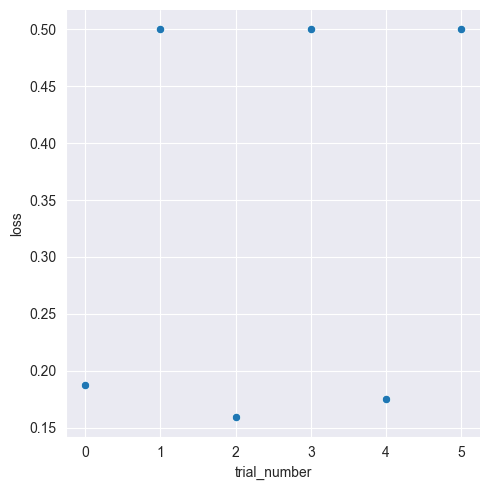

In [114]:
sns.relplot(trials_df, x = "trial_number", y = "loss")

<Axes: xlabel='trial_number', ylabel='f1'>

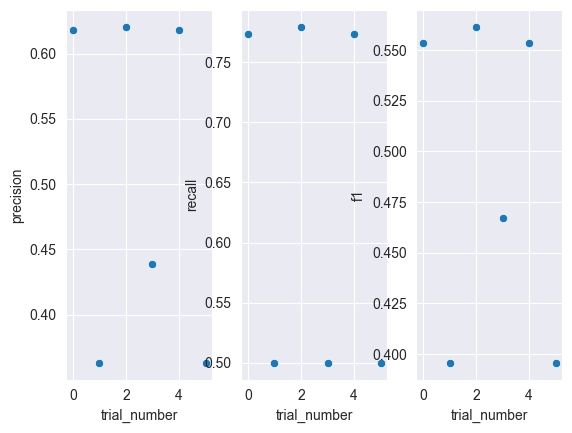

In [115]:
fig, axs = plt.subplots(ncols=3)
sns.scatterplot(x="trial_number", y='precision', data=trials_df, ax=axs[0])
sns.scatterplot(x="trial_number", y='recall', data=trials_df, ax=axs[1])
sns.scatterplot(x="trial_number",y='f1', data=trials_df, ax=axs[2])

# Fit tuned model

In [143]:
best_params = best.copy()
best_params.pop('criterion')

In [144]:
rf_tuned_initial = RandomForestClassifier( n_jobs = -1, random_state = 42,
                                   class_weight = 'balanced_subsample', **best_params, criterion = 'gini')

In [145]:
tuned_rf = Pipeline(steps=[
          ('column_tran',default),
          ('model',rf_tuned_initial)
     ])
tuned_rf.fit(Xs_train, ys_train)
pred_tuned_rf = tuned_rf.predict(Xs_val)

In [146]:
def return_eval(pred, eval):
    acc = accuracy_score(eval,pred)
    ps = precision_score(eval, pred)
    rec = recall_score(eval,pred)
    f1 = f1_score(eval, pred)
    return acc , ps ,rec, f1

return_eval(pred_tuned_rf, ys_val)

(0.693149815729087,
 0.2754078857919782,
 0.9156337182611153,
 0.42344909808020514)